# Run Analysis

This notebook analyze the information generated by the experiment I had for **m4 daily finance dataset**. The special thing about this analysis is that it compares three agents for each model: without transformation, with transformation but not the status information, and with both the tranformation and the status information.

30 time series is used. The models involved are EN, MLP, RF, LGBM, and LSVR.

In [7]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pprint import pprint

plt.rcParams['figure.figsize'] = (20, 8)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Load run information

In [2]:
plt.style.use('ggplot')

In [9]:
experiments = ['m4_daily_finance', 'm4_daily_finance_states']
run_infos = {exp: [] for exp in experiments}
for exp in experiments:
    for run in os.listdir(exp):
        with open(f'{exp}/{run}/run_info.json', 'r') as file:
            run_infos[exp].append(json.load(file))

pprint(run_infos)

{'m4_daily_finance_linear': [{'Avg. len of series': 1246.157894736842,
                              'config input': {'dataset': {'cumulate used': 0,
                                                           'file name': 'm4_daily_finance.json',
                                                           'file path': 'datasets/',
                                                           'file type': 'json',
                                                           'max length': 1500,
                                                           'min length': 1000,
                                                           'use series': 38},
                                               'execution config': {'n of workers': 22},
                                               'modelling config': {'forecast horizon': 1,
                                                                    'retrain window': 10,
                                                                    'score measure

Load agents' run information

In [16]:
agent_infos_raw = {}

for exp, runs in run_infos.items():
    for run_info in runs:
        models = run_info['config input']['models']
        run = run_info['run time'][0]
        for m in models:
            if m == 'ETS': continue

            agent_1 = f'{m}_raw'
            agent_2 = f'{m}_tran'
            agent_3 = f'{m}_tran_states'

            if 'states' in exp:
                if agent_3 not in agent_infos_raw:
                    with open(f'{exp}/{run}/{agent_2}.json', 'r') as file:
                        agent_infos_raw[agent_3] = json.load(file)
                else:
                    with open(f'{exp}/{run}/{agent_2}.json', 'r') as file:
                        agent_infos_raw[agent_3] = {**agent_infos_raw[agent_3], **json.load(file)}
            else:
                if agent_1 not in agent_infos_raw:
                    with open(f'{exp}/{run}/{agent_1}.json', 'r') as file:
                        agent_infos_raw[agent_1] = json.load(file)
                else:
                    with open(f'{exp}/{run}/{agent_1}.json', 'r') as file:
                        agent_infos_raw[agent_1] = {**agent_infos_raw[agent_1], **json.load(file)}

                if agent_2 not in agent_infos_raw:
                    with open(f'{exp}/{run}/{agent_2}.json', 'r') as file:
                        agent_infos_raw[agent_2] = json.load(file)
                else:
                    with open(f'{exp}/{run}/{agent_2}.json', 'r') as file:
                        agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}


In [28]:
agent_infos_raw = dict( sorted(agent_infos_raw.items(), key=lambda x: x[0].lower()) )

list(agent_infos_raw.keys())

['EN_raw',
 'EN_tran',
 'EN_tran_states',
 'LGBM_raw',
 'LGBM_tran',
 'LGBM_tran_states',
 'LSVR_raw',
 'LSVR_tran',
 'LSVR_tran_states',
 'MLP_raw',
 'MLP_tran',
 'MLP_tran_states',
 'RF_raw',
 'RF_tran',
 'RF_tran_states']

Check if all time series have been played successfully. Exclude those which not all agents have played successfully.

In [29]:
agent_fails = {k: [] for k in agent_infos_raw.keys()}
series_excluded = []

for agent, plays in agent_infos_raw.items():
    for series, info in plays.items():
        if info['message'] != None:
            agent_fails[agent].append(series)
            series_excluded.append(series)

if not series_excluded:
    print('All agents have successfully ran on all series.')
else:
    print(series_excluded)
    print(agent_fails)

All agents have successfully ran on all series.


Get analysis only on the series played by all agents.

In [30]:
played = [set(plays.keys()) for plays in agent_infos_raw.values()]
played_by_all = played[0].intersection(*played[1:])
print('Series played by all agents: ')
print(played_by_all)

Series played by all agents: 
{'2292', '2080', '2485', '2440', '2497', '2503', '2040', '2551', '2502', '2518', '2044', '2425', '2045', '2214', '2315', '2432', '2310', '2483', '2317', '2439', '2078', '2552', '2370', '2517', '2484', '2526', '2041', '2137', '2516', '2081'}


In [81]:
dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ]) # large, filter keys

agent_infos = {agent: dict_filter(plays, played_by_all) for agent, plays in agent_infos_raw.items()}

## Visualisation of experiment results

### Ranking of the agents

In this section, we compute the ranking of each agent per time series. So each agent will have a ranking for a time series, ranging from 1 to the number of agent involved. I store this ranking info to the `agent_infos` dictionary, as how SMAPE is stored for each agent per time series.

In [82]:
for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        score = play_info['test SMAPE']
        lower = [1 for a in agent_infos.keys() if agent_infos[a][series]['test SMAPE']-score < 0]
        play_info['ranking'] = sum(lower) + 1

## Statistics of overall performance

In this section, we calculate some statistics that concludes the general performance of each agent over the time series played.

In [83]:
numbers = {
    agent: {
        'SMAPEs': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = np.mean(numbers[agent]['SMAPEs'])
    stats[agent]['std. SMAPE'] = np.std(numbers[agent]['SMAPEs'])
    stats[agent]['mean ranking'] = np.mean(numbers[agent]['rankings'])
    stats[agent]['std. ranking'] = np.std(numbers[agent]['rankings'])

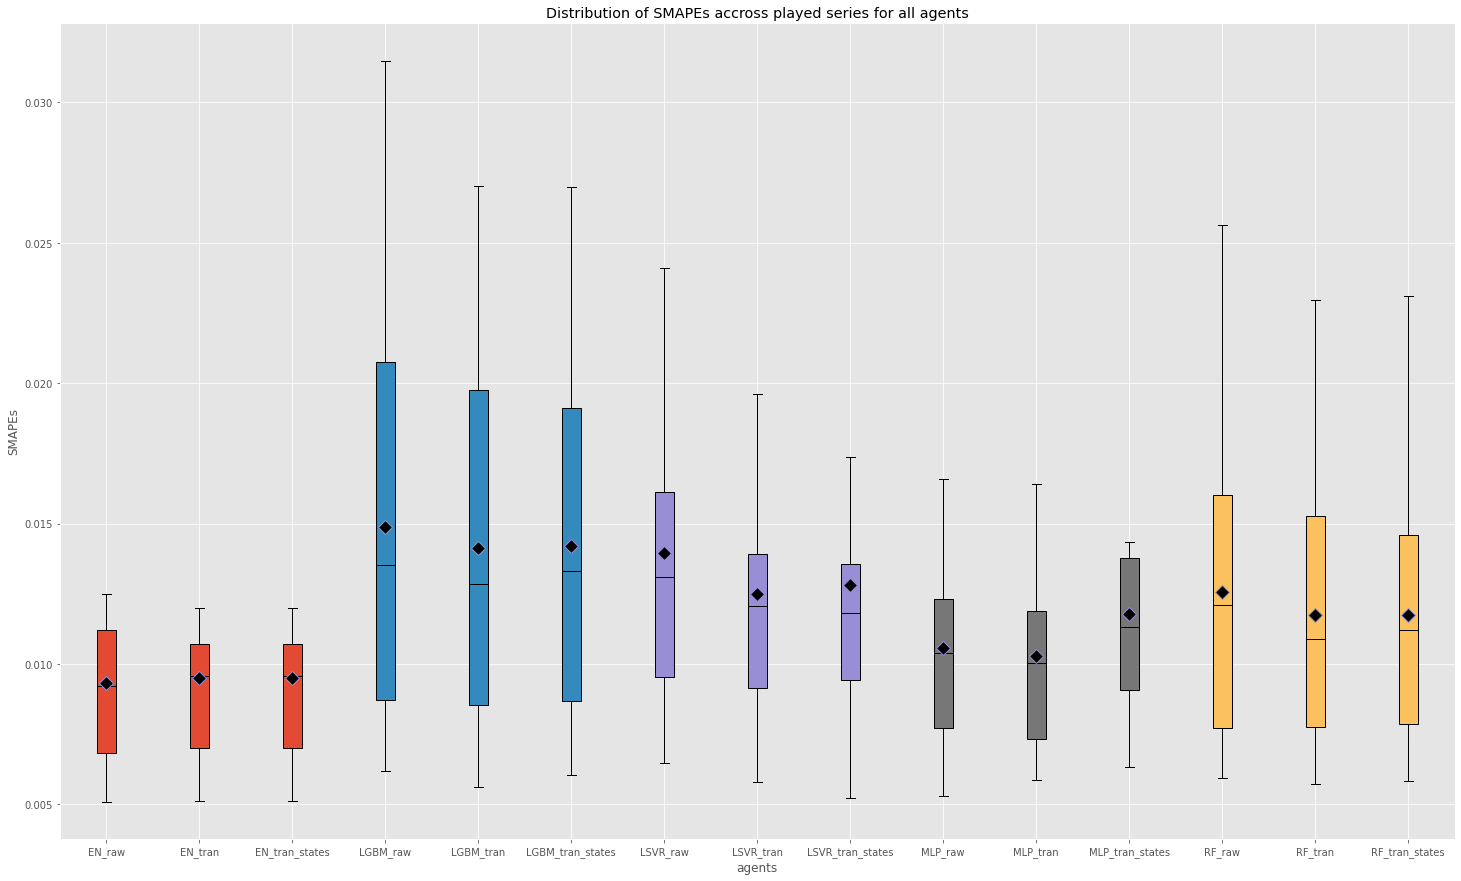

: 

In [108]:
plt.figure(figsize= (25, 15))
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//3)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)

box = plt.boxplot(
    [agent['SMAPEs'] for agent in numbers.values()],
    showbox=True,
    showfliers=False,
    labels=list(numbers.keys()),
    widths=0.2,
    showmeans=True,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//3))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of SMAPEs accross played series for all agents')
plt.xlabel('agents')
plt.ylabel('SMAPEs')
plt.show()

In this section, we compute the alpha-confidence interval of the rankings for the agents.

In [85]:
series_ran = agent_infos['MLP_raw'].keys()
n_series_ran = len(series_ran)

alpha = 0.1
Q = len(list(agent_infos.keys()))
P = n_series_ran
dist = np.random.standard_normal(size=Q)
r_lower, r_upper = np.min(dist), np.max(dist)
qrange = list(np.arange(r_lower, r_upper, step=(r_upper-r_lower)/100))
q_alpha_Q = qrange[-int(alpha*100)]

def conf_limit(Q, P, mean_R, q_alpha_Q):
    stat = 0.5 * q_alpha_Q * np.sqrt(Q*(Q+1)/(12 * P))
    return round(mean_R-stat, 6), round(mean_R+stat, 6)

for agent in agent_infos.keys():
    stats[agent][f'{100-int(alpha*100)}% ranking confi. limits'] = conf_limit(Q, P, stats[agent]['mean ranking'], q_alpha_Q)

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,EN_tran_states,LGBM_raw,LGBM_tran,LGBM_tran_states,LSVR_raw,LSVR_tran,LSVR_tran_states,MLP_raw,MLP_tran,MLP_tran_states,RF_raw,RF_tran,RF_tran_states
mean SMAPE,0.009306,0.00948,0.00948,0.014892,0.014145,0.014192,0.013953,0.012488,0.012798,0.01058,0.010266,0.011772,0.012558,0.011754,0.011729
std. SMAPE,0.003314,0.003565,0.003565,0.007426,0.006841,0.006324,0.005401,0.005121,0.008628,0.003849,0.003821,0.004162,0.00498,0.004653,0.004491
mean ranking,2.1,2.7,2.7,12.0,10.4,11.533333,11.533333,10.366667,10.133333,6.533333,4.9,10.1,9.733333,6.933333,7.333333
std. ranking,1.776701,1.791647,1.791647,2.32379,3.302524,2.305549,3.809929,4.143134,3.765929,3.116979,2.03879,2.98161,2.279376,2.90899,2.736583
90% ranking confi. limits,"(1.615543, 2.584457)","(2.215543, 3.184457)","(2.215543, 3.184457)","(11.515543, 12.484457)","(9.915543, 10.884457)","(11.048877, 12.01779)","(11.048877, 12.01779)","(9.88221, 10.851123)","(9.648877, 10.61779)","(6.048877, 7.01779)","(4.415543, 5.384457)","(9.615543, 10.584457)","(9.248877, 10.21779)","(6.448877, 7.41779)","(6.848877, 7.81779)"


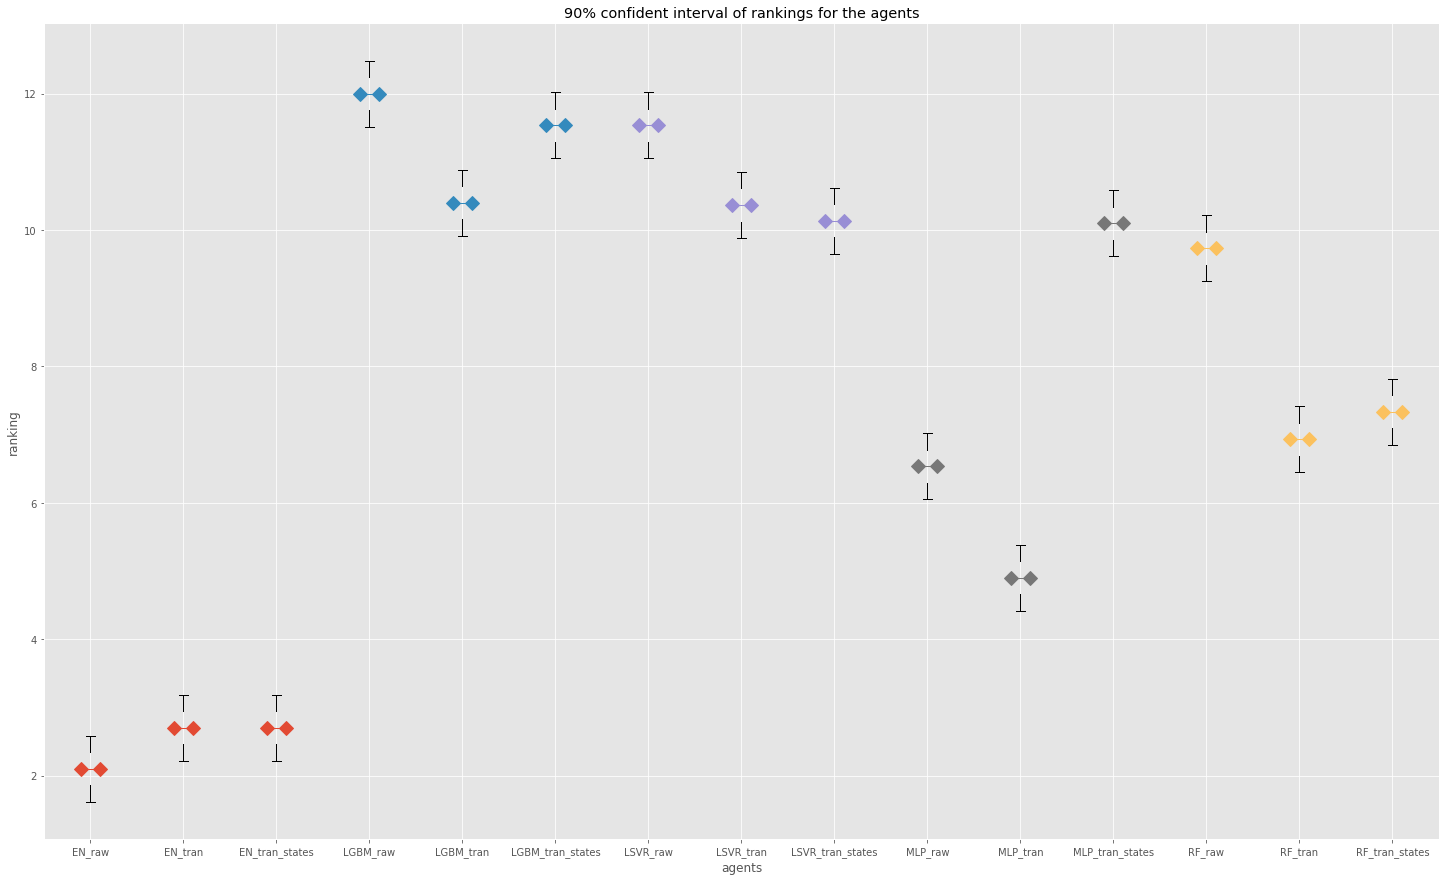

In [101]:
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//3)]
medianprop = dict(marker='D', markersize=10)
plt.figure(figsize= (25, 15))
box = plt.boxplot(
    [
        [
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][0],
            agent['mean ranking'],
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][1]
        ] for agent in stats.values()
    ],
    showbox=False,
    labels=list(numbers.keys()),
    widths=0.2,
    medianprops=medianprop,
    patch_artist=True)

for i, patch in enumerate(box['medians']):
    c = i // (n_agents//(n_agents//3))
    patch.set_color(colors[c])

plt.title(f'{100-int(alpha*100)}% confident interval of rankings for the agents')
plt.xlabel('agents')
plt.ylabel('ranking')
plt.show()

In this section, we compute another performance measure, called the fraction-best measure. Building on our basis performance measure SMAPE, we compute how much of a fraction out of all played time series that a model beats all other models. This measure lets us know the potential of an agent being exceptionally good conditional on the given datasets.

In [36]:
for agent, play_info in stats.items():
    play_info['frac best'] = np.sum([1 for r in numbers[agent]['rankings'] if r == 1])/n_series_ran

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,EN_tran_states,LGBM_raw,LGBM_tran,LGBM_tran_states,LSVR_raw,LSVR_tran,LSVR_tran_states,MLP_raw,MLP_tran,MLP_tran_states,RF_raw,RF_tran,RF_tran_states
mean SMAPE,0.009306,0.00948,0.00948,0.014892,0.014145,0.014192,0.013953,0.012488,0.012798,0.01058,0.010266,0.011772,0.012558,0.011754,0.011729
std. SMAPE,0.003314,0.003565,0.003565,0.007426,0.006841,0.006324,0.005401,0.005121,0.008628,0.003849,0.003821,0.004162,0.00498,0.004653,0.004491
mean ranking,2.1,2.7,2.7,12.0,10.4,11.533333,11.533333,10.366667,10.133333,6.533333,4.9,10.1,9.733333,6.933333,7.333333
std. ranking,1.776701,1.791647,1.791647,2.32379,3.302524,2.305549,3.809929,4.143134,3.765929,3.116979,2.03879,2.98161,2.279376,2.90899,2.736583
90% ranking confi. limits,"(1.564399, 2.635601)","(2.164399, 3.235601)","(2.164399, 3.235601)","(11.464399, 12.535601)","(9.864399, 10.935601)","(10.997732, 12.068934)","(10.997732, 12.068934)","(9.831066, 10.902268)","(9.597732, 10.668934)","(5.997732, 7.068934)","(4.364399, 5.435601)","(9.564399, 10.635601)","(9.197732, 10.268934)","(6.397732, 7.468934)","(6.797732, 7.868934)"
frac best,0.6,0.166667,0.166667,0.0,0.0,0.0,0.033333,0.033333,0.033333,0.033333,0.066667,0.0,0.0,0.0,0.033333


# MLP's choice of model complexity

MLP converges to simple linear regression when it does not have any hidden layer at all. According to *Balkin and Ord (2000)*, being able to switch to a simple linear model is a boost in performance. In the table above and in the 90/% confidence interval of the ranking graph, you can see that MLP and EN had perform similarly. This invokes the question is it because MLP had decided to switch to a linear model most of the time?

## How often did MLP converge to linear regression?

In this section, I show how often did MLP switch to simple linear regression.

In [16]:
count_agree = 0
count_lm_agree = 0
MLP_raw_struc = []
MLP_tran_struc = []
disagreed_cases = []
for s in series_ran:
    raw_struc = agent_infos['MLP_raw'][s]['best model']['struc']
    tran_struc = agent_infos['MLP_tran'][s]['best model']['struc']
    if raw_struc == tran_struc: 
        count_agree += 1
        if raw_struc == [0]:
            count_lm_agree += 1
    else:
        disagreed_cases.append(s)

    MLP_raw_struc += raw_struc
    MLP_tran_struc += tran_struc

MLP_raw_lm_count = sum([1 for x in MLP_raw_struc if x == 0])
MLP_tran_lm_count = sum([1 for x in MLP_tran_struc if x == 0])

print('MLP raw lm count: ', MLP_raw_lm_count)
print('MLP tran lm count: ', MLP_tran_lm_count)

MLP raw lm count:  209
MLP tran lm count:  152


## Do raw and tran often agree with each other on switching to linear?

I want to know whether the transformation changes when the model is going to change to linear. This is a way of answering the question: does the transformation effect how the model decide to switch the linear? If the transformed agent doesn't agree with the untransformed agent, then the tranformation itself is leading to the agents thinking differently about switching.

In [17]:
print(f'Out of {MLP_tran_lm_count} times of MLP_tran switching to linear, MLP_raw agreed with it {count_lm_agree} times.')

Out of 152 times of MLP_tran switching to linear, MLP_raw agreed with it 127 times.


## How does the transformation impact the choice of model complexity?

Another interesting question is why does untransformed MLP chose to use a linear model more often than the one with transformation? It's saying that the transformation had made the model decide to use a more complex structure. Although we did not have regularisation settings in MLP that drives the model to go for a simplier structure, does this translate into the transformation is not only an extra work itself, but also tends to make the model more complex? If that's the case, is the tranformation making the task easier for the model?

In [18]:
print(f'Out of {n_series_ran} time series ran, raw and tran agreed {count_agree} times in terms of choice of structure.')
print(f'Total avg. structure complexity for MLP_raw: {round(np.mean(MLP_raw_struc), 4)}')
print(f'Total avg. structure complexity for MLP_tran: {round(np.mean(MLP_tran_struc), 4)}')
print(f'Avg. structure complexity excluding lm for MLP_raw: {round(np.mean([x for x in MLP_raw_struc if x != 0]), 4)}')
print(f'Avg. structure complexity excluding lm for MLP_tran: {round(np.mean([x for x in MLP_tran_struc if x != 0]), 4)}')

Out of 420 time series ran, raw and tran agreed 288 times in terms of choice of structure.
Total avg. structure complexity for MLP_raw: 3.0357
Total avg. structure complexity for MLP_tran: 3.7714
Avg. structure complexity excluding lm for MLP_raw: 6.0427
Avg. structure complexity excluding lm for MLP_tran: 5.9104


Seeing that except for the cases where raw and tran disagreed with each other, they normally opt for the same complexity structure. Let's taking a deeper look in those cases with disagreement.

In [19]:
dis_raw_SMAPE = []
dis_tran_SMAPE = []
dis_raw_struc = []
dis_tran_struc = []

for s in disagreed_cases:
    dis_raw_SMAPE.append(agent_infos['MLP_raw'][s]['test SMAPE'])
    dis_tran_SMAPE.append(agent_infos['MLP_tran'][s]['test SMAPE'])
    dis_raw_struc.append(agent_infos['MLP_raw'][s]['best model']['struc'])
    dis_tran_struc.append(agent_infos['MLP_tran'][s]['best model']['struc'])

print(f'Mean SMAPE comparison in cases where raw and tran disagree in model selection (number of cases: {len(disagreed_cases)}):')
print(f'    - MLP_raw: {round(np.mean(dis_raw_SMAPE), 4)}')
print(f'    - MLP_tran: {round(np.mean(dis_tran_SMAPE), 4)}')
print(f'Avg. number of nodes in the hidden layer in these cases:')
print(f'    - MLP_raw: {round(np.mean(dis_raw_struc), 4)}')
print(f'    - MLP_tran: {round(np.mean(dis_tran_struc), 4)}')

Mean SMAPE comparison in cases where raw and tran disagree in model selection (number of cases: 132):
    - MLP_raw: 0.09
    - MLP_tran: 0.1005
Avg. number of nodes in the hidden layer in these cases:
    - MLP_raw: 2.3485
    - MLP_tran: 4.6894


To better investigate whether the transformation tends to make the model more complex, see the next section.

# EN: the transformation and model complexity

Regularisation is a mechanism that gives models incentives to opt for a less complex structure. EN has a regularisation build, which is quite easy to observe. In particular, by observing the alpha term that EN has chosen to use, we can see how hard the model decided to penalise a complex structure.

The ideas below is my suspecion:

For what reason would make the model decide to penalise complexity harder? I suspect the scale of the alpha value tells use how afraid the model is to end up being too complex. And the reason a model might opt for a complex solution is because the model sense this is a complex problem. By comparing both raw and tran given the same problem, we can see whether the tranformation tends to complicate the problem, such that the model feels the need of going for a more complex structure, and consequently levels up the penalisation to avoid ending up with a too complex model.

Note that the possible alpha values I used is (0.1, 1, 10, 100), which focuses of differentiate the scale of the penalisation. In order to compare the them, I took the log of them with base 10.

In [13]:
EN_raw_alphas = []
EN_tran_alphas = []
alpha_same_count = 0
tran_alpha_bigger_count = 0

for s in series_ran:
    raw_alpha = agent_infos['EN_raw'][s]['best model']['alpha']
    tran_alpha = agent_infos['EN_tran'][s]['best model']['alpha']
    raw_alpha_log = np.log10(raw_alpha)
    tran_alpha_log = np.log10(tran_alpha)
    EN_raw_alphas.append(raw_alpha_log)
    EN_tran_alphas.append(tran_alpha_log)
    
    if raw_alpha == tran_alpha:
        alpha_same_count += 1
    elif raw_alpha < tran_alpha:
        tran_alpha_bigger_count += 1

print(f'Number of same alpha: {alpha_same_count}')
print(f'Number of tran has bigger alpha: {tran_alpha_bigger_count}')
print(f'Avg. log alphas: (raw, tran) = ({round(np.mean(EN_raw_alphas), 4), round(np.mean(EN_tran_alphas), 4)}')

Number of same alpha: 12
Number of tran has bigger alpha: 0
Avg. log alphas: (raw, tran) = ((2.0, 2.0)


# How is the transformation doing

Let's compare whether the transformation works differently on different models. In addition to the threshold values, I also compute the difference of the threshold values for each policy. The threshold values themselves indicate how sensitive the transformation decided to be to upward and downward events respectively, while the difference indicate the trend captured by the transformation. The former is related to the diffusion of the stochastic process, which the later is related to the drift.

In [20]:
EN_thres = []
ETS_thres = []
MLP_thres = []
RF_thres = []
LSVR_thres = []
LGBM_thres = []

EN_trends = []
ETS_trends = []
MLP_trends = []
RF_trends = []
LSVR_trends = []
LGBM_trends = []

for s in series_ran:
    MLP_up, MLP_down = agent_infos['MLP_tran'][s]['best model']['thres up'],\
                agent_infos['MLP_tran'][s]['best model']['thres down']
    ETS_up, ETS_down = agent_infos['ETS_tran'][s]['best model']['thres up'],\
                agent_infos['ETS_tran'][s]['best model']['thres down']
    EN_up, EN_down = agent_infos['EN_tran'][s]['best model']['thres up'],\
                agent_infos['EN_tran'][s]['best model']['thres down']
    RF_up, RF_down = agent_infos['RF_tran'][s]['best model']['thres up'],\
                agent_infos['RF_tran'][s]['best model']['thres down']
    LSVR_up, LSVR_down = agent_infos['LSVR_tran'][s]['best model']['thres up'],\
                agent_infos['LSVR_tran'][s]['best model']['thres down']
    LGBM_up, LGBM_down = agent_infos['LGBM_tran'][s]['best model']['thres up'],\
                agent_infos['LGBM_tran'][s]['best model']['thres down']
    MLP_trends.append(MLP_up - MLP_down)
    ETS_trends.append(ETS_up - ETS_down)
    EN_trends.append(EN_up - EN_down)
    RF_trends.append(RF_up - RF_down)
    LSVR_trends.append(LSVR_up - LSVR_down)
    LGBM_trends.append(LGBM_up - LGBM_down)

    MLP_thres.append((MLP_up, MLP_down))
    ETS_thres.append((ETS_up, ETS_down))
    EN_thres.append((EN_up, EN_down))
    RF_thres.append((RF_up, RF_down))
    LSVR_thres.append((LSVR_up, LSVR_down))
    LGBM_thres.append((LGBM_up, LGBM_down))

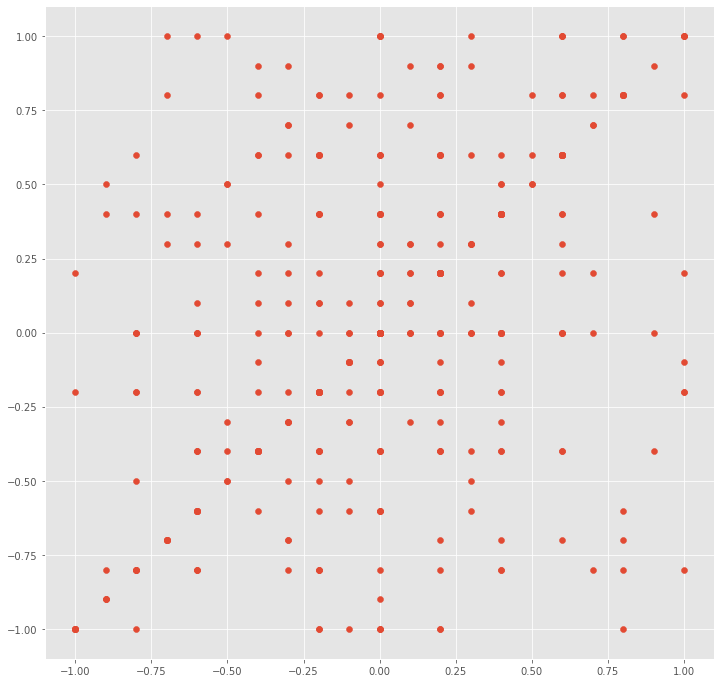

In [33]:
plt.figure(figsize=(12,12))
plt.scatter(EN_trends, MLP_trends)
plt.show()

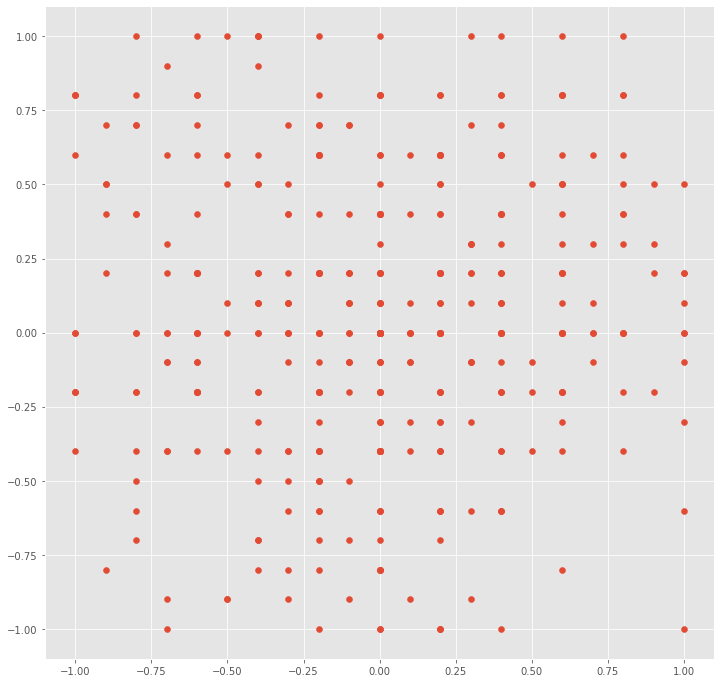

In [34]:
plt.figure(figsize=(12,12))
plt.scatter(EN_trends, ETS_trends)
plt.show()

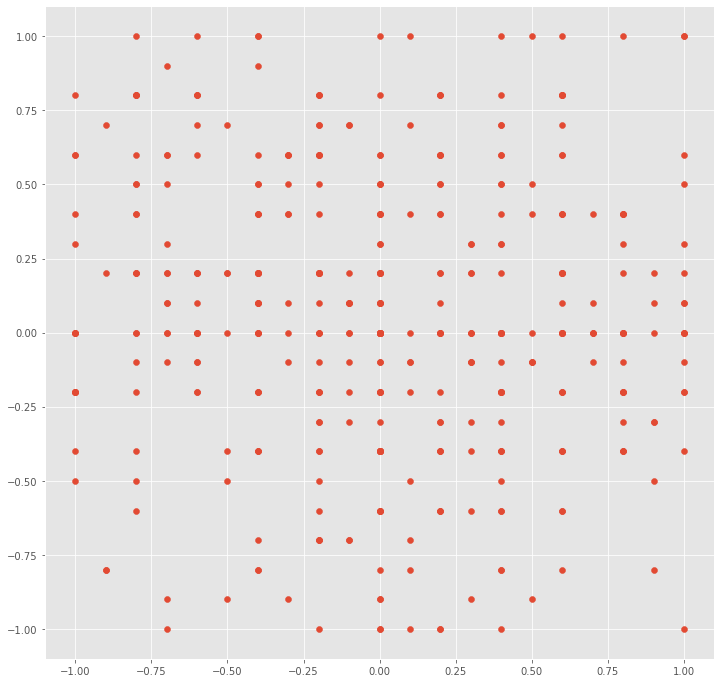

In [37]:
plt.figure(figsize=(12,12))
plt.scatter(MLP_trends, ETS_trends)
plt.show()

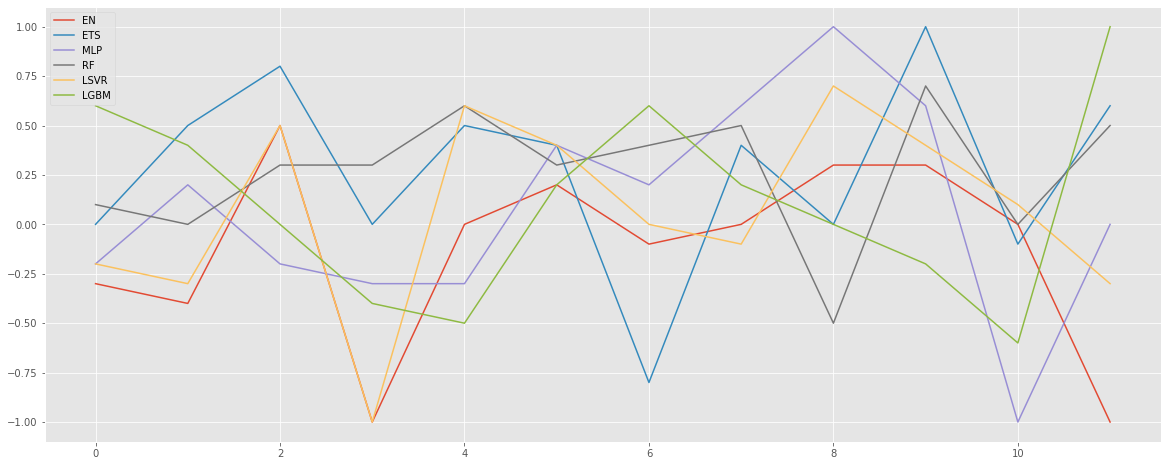

In [21]:
segment_start, segment_end = 0, 13

plt.plot(EN_trends[segment_start:segment_end], label='EN')
plt.plot(ETS_trends[segment_start:segment_end], label='ETS')
plt.plot(MLP_trends[segment_start:segment_end], label='MLP')
plt.plot(RF_trends[segment_start:segment_end], label='RF')
plt.plot(LSVR_trends[segment_start:segment_end], label='LSVR')
plt.plot(LGBM_trends[segment_start:segment_end], label='LGBM')
plt.legend()
plt.show()

In [19]:
from scipy.stats import kendalltau
# correlation measure for ordinal variables
print(kendalltau(EN_trends, ETS_trends)[0])
print(kendalltau(EN_trends, MLP_trends)[0])
print(kendalltau(ETS_trends, MLP_trends)[0])

0.16129032258064516
0.2857502857504286
0.1270001270001905


# Replicate the train to get more information

In the case of some of the information is not explicitly recorded from the experiment, there is a good chance it's implicitly contained in the recorded information. In this section, we derive the implicit information by replicating the traing using the information we have at hand.